In [1]:
import os
import csv
import copy
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False 

%matplotlib inline

## 导入数据

In [2]:
partData = pd.read_csv(open('局部异常.csv',encoding= 'utf-8'),header=None).values
partSignal = partData[0]

'''
数据的采样率和采样时间
'''
fs = 200
t_ = 10
n = fs*t_
t = np.linspace(0,t_,n)

In [ ]:
plt.plot(t,partData[0])
plt.plot(t,partData[1])
plt.plot(t,partData[2])

plt.show()

## 增加基线漂移

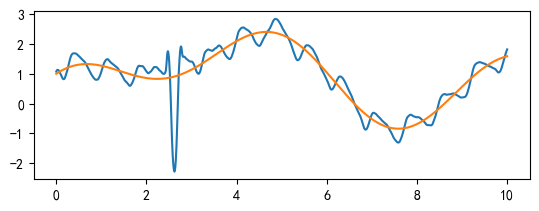

In [21]:
y1 = np.sin(2*np.pi*0.1*t)+np.sin(2*np.pi*0.05*t)+np.sin(2*np.pi*0.01*t)+np.cos(2*np.pi*0.2*t)

plt.subplot(2,1,2)
plt.plot(t,partData[0]+y1)
plt.plot(t,y1)

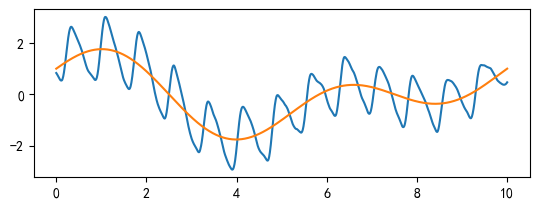

In [18]:
y2 = np.sin(2*np.pi*0.2*t)+np.cos(2*np.pi*0.1*t)

plt.subplot(2,1,1)
plt.plot(t,partData[1]+y2)
plt.plot(t,y2)

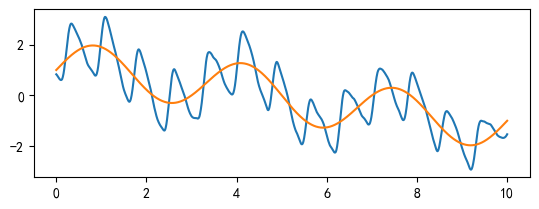

In [19]:
y3 = np.sin(2*np.pi*0.3*t)+np.cos(2*np.pi*0.05*t)

plt.subplot(2,1,1)
plt.plot(t,partData[1]+y3)
plt.plot(t,y3)

## 增加高频噪声

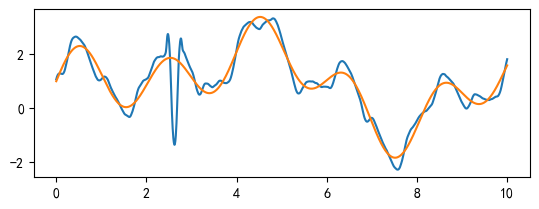

In [26]:
z1 = y1 + np.sin(2*np.pi*1000*t)

plt.subplot(2,1,2)
plt.plot(t,partData[0]+z1)
plt.plot(t,z1)

## 预处理

In [28]:
'''
一开始就是处理好的
'''

'\n一开始就是处理好的\n'

## 方向异常和局部异常处理

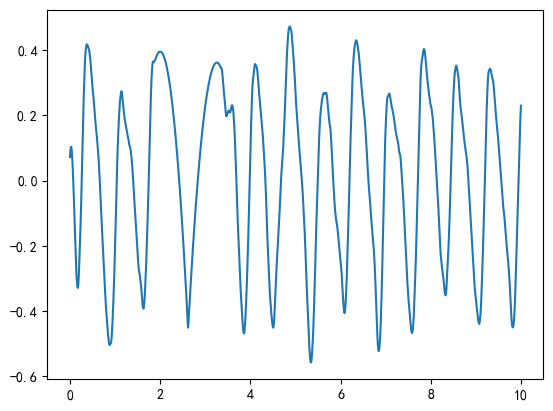

In [30]:
def getTnum(Signal):
    XPower = abs(fft(Signal))
    XPower = XPower[0:100]
    loc = np.where(XPower==max(XPower))[0][0]
    zhuPin = loc/10
    T = 1/zhuPin
    fs = 200
    Tnum = int(round(T*fs))
    return Tnum

def getMaxMin(signal,x):
    maxLoc = int(np.where(signal == max(x))[0][0])
    minLoc = int(np.where(signal == min(x))[0][0])

    return max(x),min(x),maxLoc,minLoc

def getPeakAndTrough(Signal,alpha = 0.8):
    X = Signal
    
    MAX = []
    MIN = []
    MAXLOC = []
    MINLOC = []

    # alpha = 2/3
    
    Tnum = getTnum(X)
    halfT = int(Tnum/2)
    a = 0
    b = int((alpha)*Tnum)
    for i in range(int(np.ceil(len(X)/Tnum))):
        x = X[a:b]
        Max,Min,maxLoc,minLoc = getMaxMin(X,x)
        MAX.append(Max)
        MIN.append(Min)
        MAXLOC.append(maxLoc)
        MINLOC.append(minLoc)

        a = maxLoc+halfT
        b = a+int((alpha)*Tnum)

    return MAXLOC,MAX,MINLOC,MIN

def chaZhi(threeX,threeY,length):
    '''
    二阶B样条插值
    '''
    from scipy.interpolate import interp1d
    
    xx = np.linspace(min(threeX),max(threeX), length)
    f = interp1d(threeX, threeY, kind = 'quadratic')
    return f(xx)

partSignal = partData[0]



MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(partSignal, alpha=0.8)

'''
右下支
'''

i = 3
threeX = [ MAXLOC[i-1],MAXLOC[i-1]+abs(MAXLOC[i-1]-MINLOC[i])*3/4,MINLOC[i],]
threeY = [ MAX[i-1],(MAX[i-1]+np.median(MIN))*1/2,np.median(MIN), ]
length = MINLOC[i] - MAXLOC[i-1]

chaZhiResult = chaZhi(threeX,threeY,length)

'''

左上支
'''

i = 3
threeX_2 = [ MINLOC[i],MINLOC[i]+abs(MINLOC[i]-MAXLOC[i+1])*1/4,MAXLOC[i+1] ]
threeY_2 = [ np.median(MIN),(MAX[i+1]+np.median(MIN))*1/2 ,MAX[i+1]]
length_2 = MAXLOC[i+1] - MINLOC[i]

chaZhiResult_2 = chaZhi(threeX_2,threeY_2,length_2)

import copy
X = copy.deepcopy(partSignal)
X[MAXLOC[2]:MINLOC[3]] = chaZhiResult
X[MINLOC[3]:MAXLOC[4]] = chaZhiResult_2

plt.figure()
plt.plot(t,X)
plt.show()